# Transformer의 깊은 이해
트랜스포머를 로우레벨부터 구현해보도록 하겠습니다.  
트랜스포머를 한층 한층 직접 쌓아보이시면 추후에 트랜스포머 계열들을 쉽게 이해하실 수 있습니다.  
**나중에 계속 트랜스 포머 계열인 Bert, XLnet, ALBERT, Reformer 등을 공부하시면서 어려움에 봉착할 때마다 만성적으로 고민하며 시간을 날리는 것보다는, 지금 한번 제대로 이해하시면 훗날 크게 도움이 될 것이라 믿습니다.**  

https://www.tensorflow.org/tutorials/text/transformer 를 쉽게 구현하고 이해할 수 있도록 코드를 약간 수정하였습니다.  
포르투갈어를 영어로 번역하는 Seq2Seq 예제를 통해서 트랜스포머에 익숙해져 보기로 하겠습니다.  

직관적인 설명은 이 사이트에 더 잘 되어 있으며, 저는 직접 실행해보는 관점에서 설명드리고자 합니다. 시각적 설명을 원하시면 이 사이트에 접속하시기 바랍니다.
http://jalammar.github.io/illustrated-transformer/  
이번 강의에서는 **포르투갈어를 영어로 바꾸는 Seq2Seq** 문제를 **Transformer를 활용하여 해결해 보도록 하겠습니다.**  
![Imgur](https://i.imgur.com/Z0QOeAG.png)

# 데이터 로드
데이터 로드는 tensorflow 2에서 제공하는 tf.data.dataset 형식으로 로드하도록 하겠습니다. dataset 형식으로 데이터를 불러오면, 향후 모델을 훈련시킬 때 @tf.function 데코레이터를 활용하여 상당히 빠르게 학습할 수 있습니다.

In [1]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 25 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,392 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 19s (23.2 MB/s)
(Reading database ... 129496 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.1.1.33-1+cuda11.2 t

In [2]:
# 포르투갈어-프랑스어 데이터 로드를 위한 임포트
import tensorflow_datasets as tfds

In [3]:
# 분석에 필요한 모듈 임포트
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [8]:
# 데이터 불러오기
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)

In [ ]:
# 데이터가 test, train, validation에 있음
# 이 데이터들의 형식은 tf.data.dataset 오브젝트
examples

In [ ]:
type(examples['train'])

In [10]:
# train, validation, test 데이터로 나누기
train_examples, val_examples, test_examples = examples['train'], examples['validation'], examples['test']

In [11]:
# 시간이 좀 걸리는데 정상입니다.
# train_example 에는 포르투갈어 pt, 영어 en이 있음
# 여기서 단어를 추출해서, 단어들마다 인덱싱을 부여할 것임
# 인덱싱을 부여하는 클래스가 tokenizer_en(영어 인덱싱 부여), tokenizer_pt(포르투갈어 인덱싱 부여)

tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [12]:
# 영어를 인코딩
tokenizer_en.encode("Hello man, Let's run transformer!")

[7903, 2429, 439, 406, 7345, 7907, 1283, 7870, 9, 527, 6514, 7945, 7864]

In [13]:
# 포르투갈어를 인코딩
print(tokenizer_pt.encode("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."))

[141, 77, 33, 1566, 873, 4501, 217, 642, 4, 217, 101, 1073, 4824, 17, 5, 488, 200, 8004]


In [18]:
def encode(lang1, lang2):

  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1] # 포르투갈 어를 인코딩 할 때 시작 단어를 의미하는 숫자와, 끝 단어를 의미하는 숫자가 붙음
  
  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1] # 영어도 마찬가지임

  return lang1, lang2

In [19]:
lang1 = tf.constant("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.", dtype=tf.string)
lang2 = tf.constant("Hello man, Let's run transformer!", dtype=tf.string)

In [20]:
print(encode(lang1, lang2))

([8214, 141, 77, 33, 1566, 873, 4501, 217, 642, 4, 217, 101, 1073, 4824, 17, 5, 488, 200, 8004, 8215], [8087, 7903, 2429, 439, 406, 7345, 7907, 1283, 7870, 9, 527, 6514, 7945, 7864, 8088])


In [21]:
# tf.py_function을 활용하여 모든 문장에 숫자를 부여함

def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64]) # 인풋 값으로 pt와 en이 한문장 한문장씩 들어가서 result_pt, result_en을 아웃풋으로 내게 됨
  result_pt.set_shape([None])
  result_en.set_shape([None])
  return result_pt, result_en

In [22]:
MAX_LENGTH = 40
BUFFER_SIZE = 60000
BATCH_SIZE = 64

# 전체 데이터에서 x가 포르투갈어 한 문장, y가 영어 한 문장인데
# 만약 문장이 인코딩 되었을 때, 인코딩 된 길이가 40을 초과하면 데이터에서 배제하고자 하는 필터 함수임
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [23]:
train_dataset = train_examples.map(tf_encode) # tf_encode 함수를 활용해서 포르투갈어, 영어 각 문장에 시작 토큰과 끝 토큰을 부여함
train_dataset = train_dataset.filter(filter_max_length) # 문장의 길이가 40이 넘는 문장은 배제하고자 함
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache() # cache를 활용해서 데이터를 로드할 때 빠른 처리를 기대해 봄
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE) 
# shuffle(60000) 인데, 이 말은 전체 데이터를 완전히 섞겠다는 뜻임
# 전체 데이터의 수가 50000인데 50000보다 큰 숫자를 입력하면 완전하게 전체 데이터를 섞는 것이며
# 전체 데이터 수보다 작은 수를 입력하면 전체 데이터에서 일부만 섞음
# padded_batch는 무엇이냐면, 이번 데이터셋은 문장마다 길이가 모두 다르기에
# 배치 사이즈(32) 만큼의 문장을 뽑을 때마다
# 배치 사이즈에 해당하는 만큼의 문장의 길이는 일정하게 유지됨
# 무슨 말이냐면 배치가 2개라면  이 중 하나의 문장의 길이는 37이 될 수 있고
# 두 개의 배치(32) 중 하나의 배치는 문장의 길이를 37개로 모두 유지
# 그 다음 배치에서 문장의 길이가 39 라면, 그 배치에서는 문장의 길이를 39로 유지
                                                                            
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE) # 데이터 로드와 처리의 시간을 overlap하여 속도 향상

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE) #가변길이의 배치를 돌릴때 꼭 쓰자

#트랜스포머 구조
트랜스포머 트랜스포머의 구조는 
1. (위치 + 단어 임베딩) -> 2, 인코더 3. 디코더로 나뉩니다.  

먼저 임베딩부터 살펴보도록 하겠습니다.

![Imgur](https://i.imgur.com/Tl2zsFL.png)

#임베딩 파트 정의
트랜스포머는 단어 임베딩 + 위치 임베딩, 두 가지 임베딩을 거치게 되며  
단어 임베딩은 많이 해봤기 때문에, 위치 임베딩만 살펴 보도록 하겠습니다.  
**왜 위치 임베딩을 하나면 RNN 계열 같이 문장 내부 단어의 순서를 나타낼 방법이 없기 때문입니다.**  
같은 단어라도 위치 임베딩 때문에 순서에 따라서 단어가 임베딩 된 것은 다를 수 있습니다.  
![Imgur](https://i.imgur.com/sSnVRpY.png)

![Imgur](https://i.imgur.com/SNIEhlA.png)

In [25]:
# 먼저 포지셔널 임베딩부터
# pos / 10000 ** (2i / d_model)에 해당하는 부분을
# get_angles 함수로 출력하기

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i // 2) / np.float32(d_model)))
    # shape = (1, d_model)
  return np.matmul(pos, angle_rates) # pos shape : (pos, 1), angle_rates shape = (1, d_model),
                                     # np.matmul(pos, angle_rates) shape : 행렬곱 (pos,1), (1, d_model) = (pos, d_model)

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model) # shape : (position, d_model)
  # 오른쪽으로 짝수번째 인덱스는 sin 함수를 적용
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  # 오른쪽으로 홀수번째 인덱스는 cos 함수를 적용
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...] # pos_encoding shape : (1, position, d_model)
                                             # 왜 shape에 1을 추가해주냐면, batch_size 만큼 학습하기 위함임

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


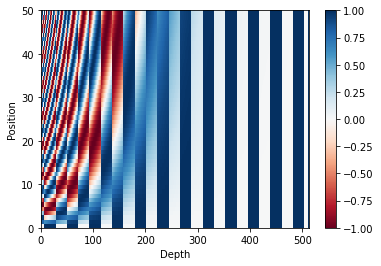

In [26]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

단어 임베딩 + 포지셔널 임베딩 클래스 구현  
주의할 점은 포지셔널 단어임베딩 * sqrt(임베딩 차원), 즉 루트가 곱해져야함  
위치 임베딩은 단순히 위치만 나타내기 때문에, 가중치가 단어 임베딩보단 적어야 신경망이 잘 학습됨

In [28]:
class TransformerEmbedding(tf.keras.layers.Layer):
  def __init__(self, d_model, input_vocab_size, maximum_position_encoding, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model # 하나의 단어가 d_model의 차원으로 인코딩 됨
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
     # vocab_size는 tokenizer 내부 vocab.txt의 사이즈
    self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model) # 포지셔널 인코딩
    self.dropout = tf.keras.layers.Dropout(dropout_rate) # 드롭아웃 설정
    

  def call(self, x, training):
    # 최초 x의 shape = (batch_size, seq_len)
    seq_len = tf.shape(x)[1]
    out = self.embedding(x) # shape : (batch_size, input_seq_len, d_model)
    out = out * tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # x에 sqrt(d_model) 만큼을 곱해주냐면, 임베딩 벡터보다 포지셔널 인코딩 임베딩 벡터의 영향력을 줄이기 위해서임
                                                            # 포지셔널 인코딩은 순서만을 의미하기 때문에 임베딩 벡터보다 영향력이 적어야 이치에 맞음
    out = out + self.pos_encoding[:,:seq_len,:]
    out = self.dropout(out, training=training)
    

    return out # shape : (batch_size, input_seq_len, d_model)

In [29]:
x = np.float32(np.random.uniform(size=(1,40))) # 문장 길이 40
Embedder = TransformerEmbedding(512, tokenizer_en.vocab_size+2, 10000)
embedded = Embedder(x, False)
print(embedded) # 문장이 위치 임베딩 + 포지션 임베딩

tf.Tensor(
[[[-0.5484167   0.00309396 -0.31679618 ...  1.7556027   0.03698184
    0.21782684]
  [ 0.29305428 -0.45660377  0.50506    ...  1.7556027   0.0370855
    0.21782684]
  [ 0.36088073 -1.4130529   0.61961854 ...  1.7556027   0.03718916
    0.21782684]
  ...
  [-1.1919549  -0.23149198 -1.2233138  ...  1.7555947   0.04081737
    0.21781951]
  [-0.2520481  -0.04183239 -1.180196   ...  1.7555944   0.04092103
    0.2178191 ]
  [ 0.4153787  -0.7302631  -0.39402786 ...  1.755594    0.04102469
    0.21781868]]], shape=(1, 40, 512), dtype=float32)


# 스케일드 닷 프로덕트 어텐션
문장이 셀프 어텐션 되어서 어텐션 값과, 소프트맥스 함수를 출력하는 함수를 만들고자 합니다. scaled라는 의미는, 루트(단어의 차원 512)만큼 어텐션 값에서 나눠져 스케일링이 되기 때문에 스케일드 닷 프로덕트 어텐션이라는 이름이 붙여진 것입니다.  
![Imgur](https://i.imgur.com/9fmQJl9.png)  
제 깃허브에 올린 **심화1_어텐션의 근본적인 이해** 에서 어텐션 부분과 다른 점이 거의 없으니 복습하시면 됩니다.  
mask를 True로 설정하면 소프트맥스 아웃풋에서, 마스크 된 부분은 0으로 바뀌게 됩니다. 왜냐면 -1e9는 상당히 큰 값인데, e^(-1e9)는 0에 수렴하기 때문입니다.  
왜 트랜스포머에 마스크가 들어가는 지는 두 가지로 말씀드리겠습니다. **1) 인풋의 길이를 신경망 학습을 위해 일정한 길이로 맞추다 보면, 원래 문장의 길이를 초과하는 만큼은 패딩이 됩니다. 그 패딩한 부분을 어텐션 연산에 참여시키지 않기 위해 마스크를 사용하는 것입니다.**  
**2) Seq2Seq같은 기계 번역을 할 때에는 인코딩 부분과 단어 일부로 다음 단어를 예측하기 때문에, 단어 전체를 훈련하지 않고 일부분만 훈련하는 것이 논리에 맞습니다. 따라서 mask로 훈련에 필요하지 않은 부분은 0으로 바꿔주게 됩니다.**


문장들이 임베딩되면 인풋의 차원은 (batch_size, seq_len, d_model)입니다.  
scaled_dot_product_attention 이후의 차원 또한 (batch_size, seq_len, d_model)입니다.  
**즉 인풋과 아웃풋의 사이즈가 동일하게 됩니다.**  

따라서 scaled_dot_product_attention의 결과는 단어들 간의 연관성을 학습한다고 이해하시면 되겠습니다.

In [30]:
def scaled_dot_product_attention(q, k, v, mask=None):
  # q shape : (batch_size, seq_len, d_model)
  # k shape : (batch_size, seq_len, d_model)
  # v shape : (batch_size, seq_len, d_model)
  matmul_qk = tf.matmul(q, k, transpose_b = True)
  #matmul_qk shape : (batch_size, seq_len, seq_len)                                                

  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # scaled_attetion_logits shape : (batch_size, seq_len, seq_len)

  if mask is not None:
    scaled_attention_logits = scaled_attention_logits + (mask * -1e9)

  softmax = tf.nn.softmax(scaled_attention_logits, axis=-1)

  # softmax shape : (batch_size, seq_len, seq_len)

  output = tf.matmul(softmax, v)

  # output(attention_value) shape : (batch_size, seq_len, d_model)
  # 즉 처음 입력 차원인 (batch_size, seq_len, d_model) 차원을 아웃풋으로 반환

  return output, softmax

In [31]:
q = tf.cast(np.random.uniform(size=(1,2,512)), dtype=tf.float32)
k = tf.cast(np.random.uniform(size=(1,7,512)), dtype=tf.float32)
v = tf.cast(np.random.uniform(size=(1,7,512)), dtype=tf.float32)
scaled_dot_product_attention(q,k,v)

(<tf.Tensor: shape=(1, 2, 512), dtype=float32, numpy=
 array([[[0.4557653 , 0.560415  , 0.54242533, ..., 0.47352362,
          0.54639184, 0.38772118],
         [0.44678533, 0.5727357 , 0.5380274 , ..., 0.4890948 ,
          0.5451081 , 0.40459323]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2, 7), dtype=float32, numpy=
 array([[[0.14637142, 0.13290583, 0.13682967, 0.11283391, 0.15703452,
          0.17080767, 0.14321697],
         [0.13575438, 0.14492726, 0.15737596, 0.13146915, 0.15412728,
          0.13943662, 0.13690943]]], dtype=float32)>)

# 멀티 헤드 어텐션 정의
멀티 헤드 어텐션은 전체 어텐션을 분리하여 병렬적으로 어텐션을 수행하는 기법입니다.  
즉 (batch_size, 50, 64*8) 의 텐서가 있다면 이것을 (batch_size, 50, 64) 의 8개의 텐서로 나눈다음에 개별적으로 어텐션을 수행하고, 다시 (batch_size, 50, 64*8)의 텐서로 concat(합치는) 하게 됩니다.  
이렇게 하는 이유는, 깊은 차원을 한번에 어텐션을 수행하는 것보다, 병렬로 각각 수행하는 것이 더 심도있는 언어들간의 관계를 학습할 수 있기 때문입니다.

In [32]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super().__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0,2,1,3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)

    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)


    attention_weights, softmax = scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = tf.transpose(attention_weights, perm=[0,2,1,3])

    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

    output = self.dense(concat_attention)

    return output, softmax

In [33]:
q = tf.cast(np.random.uniform(size=(1,2,512)), dtype=tf.float32)
k = tf.cast(np.random.uniform(size=(1,7,512)), dtype=tf.float32)
v = tf.cast(np.random.uniform(size=(1,7,512)), dtype=tf.float32)
temp_mha = MultiHeadAttention(512, 8)
encoder_output, _ = temp_mha(v,k,q, mask=None)
print(encoder_output)

tf.Tensor(
[[[-0.04296089  0.4174242  -0.04100064 ...  0.10953632 -1.3755398
   -0.29621586]
  [-0.03043575  0.40808594 -0.04436496 ...  0.10540938 -1.3548124
   -0.29027122]]], shape=(1, 2, 512), dtype=float32)


# 포인트와이즈 피드 포워드 네트워크 정의
Pointwise Feed Forward 네트워크에서는 인코더의 출력에서 512개의 차원이 2048차원까지 확장되고,  
다시 512개의 차원으로 압축됩니다.

In [34]:
class Pointwise_FeedForward_Network(tf.keras.layers.Layer):
  def __init__(self, d_model, dff):
    super().__init__()
    self.d_model = d_model
    self.dff = dff

    self.middle = tf.keras.layers.Dense(dff, activation='relu')
    self.out = tf.keras.layers.Dense(d_model)

  def call(self, x):
    middle = self.middle(x) # middle shape : (batch_size, seq_len, dff)
    out = self.out(middle) # out shape : (batch_size, seq_len, d_model)
    return out

In [35]:
sample_PFFN = Pointwise_FeedForward_Network(512, 2048)
sample_PFFN(encoder_output)

<tf.Tensor: shape=(1, 2, 512), dtype=float32, numpy=
array([[[-0.2563562 , -0.22325876, -0.32178918, ..., -0.16631718,
          0.17953217,  0.19073486],
        [-0.25964034, -0.22173429, -0.3199656 , ..., -0.1781463 ,
          0.18642169,  0.19793534]]], dtype=float32)>

# 인코더, 디코더 정의
지금까지 임베딩 -> 멀티 헤드 어텐션 -> 포인트와이즈 피드 포워드 네트워크까지 살펴 보았습니다.  
트랜스포머에서의 인코딩은 (멀티헤드어텐션 + 포인트와이즈 피드 포워드 네트워크)를 층층이 쌓은 것입니다. 따라서 방금 공부했던 멀티헤드 어텐션과 포인트와이즈 피드 포워드 네트워크를 겹겹이 쌓아서, 인코더층을 쌓는 것입니다.  

인코더 레이어를 정의해서 멀티헤드 어텐션과 포인트와이즈 피드 포워드 네트워크를 합쳐 보도록 하겠습니다. 

단어 임베딩 벡터(단어 임베딩+위치 임베딩)가 -> 1. 멀티헤드어텐션  -> 2. Residual Network를 거쳐 원래 input과 멀티헤드어텐션의 합이 출력 -> 3. 포인트와이즈 피드포워드 네트워크 를 거치고, -> 4. Residual Network를 거쳐서 원래의 인풋과 포인트와이즈 피드포워드 네트워크의 합이 출력됨  
![Imgur](https://i.imgur.com/w4n19Rs.png)

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super().__init__()
    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = Pointwise_FeedForward_Network(d_model, dff)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def call(self, x, training, mask=None):
    # x : 위치 임베딩 + 단어 임베딩 된 인코딩의 인풋
    attn_output, _ = self.mha(x, x, x, mask) 
    # 멀티헤드 어텐션
    # attn_output shape : (batch_size, input_seq_len, d_model)

    attn_output = self.dropout1(attn_output, training=training)

    out1 = self.layernorm1(x + attn_output) # Residual Network 거침, 레이어 노멀레이제이션을 통한 값 평준화

    ffn_output = self.ffn(out1) # ffn_output_shape : (batch_size, input_seq_len, d_model), 포인트와이즈 피드포워드 네트워크
    ffn_output = self.dropout2(ffn_output, training=training)

    out2 = self.layernorm2(out1 + ffn_output)   # Residual Network 거침
                                                # out2 shape : (batch_size, input_seq_len, d_model)

    return out2

In [ ]:
# 임베딩
x = np.float32(np.random.uniform(size=(1,40))) # 문장 길이 40
Embedder = TransformerEmbedding(512, tokenizer_en.vocab_size+2, 10000)
embedded = Embedder(x, False)
print(embedded) # 문장이 위치 임베딩 + 포지션 임베딩
#인코더
sample_encoder = EncoderLayer(d_model=512, num_heads=8, dff=2048, rate=0.1)
sample_encoding = sample_encoder(embedded, training=None, mask=None)
print(sample_encoding)
#최종출력
print("Encoded 차원 :", sample_encoding.shape)

디코더를 정의하도록 하겠습니다.  
![Imgur](https://i.imgur.com/kGTfPr8.png)

디코더는 인코더랑 유사하지만, 구조가 약간 다릅니다. 
이번 Seq2Seq는 포르투갈어를 영어로 바꾸는 문제입니다.  디코더에서는 
두단계의 멀티 헤드 어텐션 구조를 거치는데, **첫번째 멀티 헤드 어텐션은**, **영어문장과 영어문장의 셀프 어텐션을 하여**, 영어 문장간의 관계를 배우게 됩니다.  
두번째 멀티 헤드 어텐션은 **포르투갈어가 인코딩 된 것과**, **영어 문장간의 셀프** **어텐션된 결과를 다시 어텐션 해서 포르투갈 어와 영어의 관계를 학습하게 됩니다.**  

포르투갈어가 암호화된 것과, 영어 문장 한단어 한단어를 보면서 다음 단어를 예측하게 되기 때문에, look_ahead_mask를 사용하게 됩니다.  
만약 영어 문장이 (I love you) 로 이루어져 있다면, look_ahead_mask를 사용하면,  
(I, 0, 0) -> Love 예측, (I love, 0) -> You 예측, (I love you) -> 단어의 끝인 [SEP] 예측을 합니다.   
**즉 look_ahead_mask는 다음 단어를 예측할 때, 전에 있던 단어만으로 예측할수 있도록 앞에 있는 단어는 가리는 것입니다.**
  
  이러한 역할을 가능하게 하는 mask가 look_ahead_mask 입니다.

look_ahead_mask를 알아보겠습니다.**(매우 중요)**  
참고로 패딩은 1로 하겠습니다. 왜냐하면 어텐션 부분에서 mask * (-1e9)를 하는데, 패딩이 1이어야 -1e9가 곱해져서 상당히 음수로 큰 수가 되는 것이고, 이게 소프트 맥스에 들어가면 0이 되기 때문입니다.(지수함수라 지수함수에 -음수는 0으로 수렴)  
![Imgur](https://i.imgur.com/eLAlzji.png)  
![Imgur](https://i.imgur.com/gAVenk0.png)  
![Imgur](https://i.imgur.com/hsZ6dGs.png)

In [ ]:
# 상삼각행렬 만들기
tf.linalg.band_part(tf.ones((10, 10)), -1, 0)

In [ ]:
temp_mask = 1 - tf.linalg.band_part(tf.ones((40, 40)), -1, 0)
print(temp_mask)

In [ ]:
# 예제 문장 (1, 40) 즉, 1문장, 40개의 단어를 가짐
example_sentence = np.hstack([np.random.randint(20, size=10), np.zeros(30)])[np.newaxis, :]
print(example_sentence) # 예제 문장
example_sentence = tf.cast(tf.math.equal(example_sentence, 0), dtype=tf.float32)
print(example_sentence) # 패딩 된 것(문장에서 0이 아닌 부분은 0으로, 0인 부분은 1로)
example_sentence = example_sentence[:, tf.newaxis, tf.newaxis, :] # 차원 변경
print(example_sentence)

look_ahead_mask = tf.maximum(temp_mask, example_sentence) # 상삼각행렬과 example sentence를 비교해가며 최대값만 취해서 패딩을 1로 처리함
# look ahead mask
print(look_ahead_mask)

In [ ]:
# look_ahead_mask 알아보기
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask
  
def create_masks(tar):
  temp_mask = create_look_ahead_mask(tf.shape(tar)[1])
  
  
  reverse_tar = tf.cast(tf.math.equal(tar, 0), dtype=tf.float32)
  reverse_tar = reverse_tar[:,tf.newaxis,tf.newaxis,:]
  look_ahead_mask = tf.maximum(reverse_tar, temp_mask)


  return look_ahead_mask

또한 패딩 마스크를 두어서, 패딩인 부분은 1으로 처리하겠습니다.

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
example_sentence = np.hstack([np.random.randint(20, size=10), np.zeros(30)])[np.newaxis, :]
# 패딩 되기 전
print(example_sentence)
# 패딩 된 후
print(create_padding_mask(example_sentence))

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super().__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)
    
    self.ffn = Pointwise_FeedForward_Network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training, padding_mask, look_ahead_mask):
    # x : 훈련 과정에서는 Seq2Seq에서 번역이 될 문장이 입력됨,
    # x : 추론 과정에서는 과거의 단어가 입력됨
    # enc_output : 인코더의 출력
    # padding_mask : 멀티 헤드 어텐션에 필요한 정보만 남기고 나머지는 패딩 처리
    # look_ahead_mask : 위에 설명
    # enc_output_shape == (batch_size, input_seq_len, d_model)

    #### 첫번째 멀티 헤드 어텐션 파트임 ####
    #### 첫번째 멀티 헤드 어텐션은, 인코더와의 결합 없이 번역이 될 문장끼리만 어텐션을 함 ####
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
    out1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(out1 + x)
    
    #### 두번째 멀티 헤드 어텐션 파트임 ####
    #### 두번째 멀티 헤드 어텐션 파트는 enc_output에서 인코더와(포르투갈어), out1(영어문장으로만 셀프어텐션을 한 것)
    #### 이 다시 멀티 헤드 어텐션 과정을 거치게 됨
    #### 다시 상기하자면, 이번 과제는 포르투갈 어를 영어로 번역하는 것임
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)
    out2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(out2 + out1) # (batch_size, target_seq_len, d_model)
    

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2) # (batch_size, target_seq_len, d_model)
    

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)
sample_decoder_layer_output, _, _ = sample_decoder_layer(embedded, sample_encoding, False, None, None)
print(sample_decoder_layer_output)
print(sample_decoder_layer_output.shape)

이제 여러 층의 인코더를 쌓는 Encoder Class를 정의해보도록 하겠습니다.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)] # 인코더를 쌓아서 층을 만듦


  def call(self, x, training, mask):
    # 인풋은 타겟 임베딩 + 포지셔닝 임베딩
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x # 출력 모양 : (batch_size, input_seq_len, d_model), 인코더의 층을 출력으로 내보냄

In [ ]:
Encoder_layer = Encoder(6, 512, 8, 2048) #6층, 512차원의 단어 임베딩, 8개의 병렬 멀티 헤드 어텐션의 인코더
# embedded : 위치 임베딩 + 단어 임베딩
Encoded = Encoder_layer(embedded, False, None)
print(Encoded, Encoded.shape)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]


  def call(self, x, enc_output, training, padding_mask, look_ahead_mask):
    attention_weights = {}

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training, padding_mask, look_ahead_mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    return x, attention_weights

In [ ]:
# 위치 임베딩 + 포지셔널 임베딩
embedded
#인코더 아웃풋 
Encoded

# 디코더의 위치+포지셔널 임베딩(Teaching Force 과정이라 디코더 부분에 타겟(영어)도 넣어줌)
target_embedder = TransformerEmbedding(d_model=512, input_vocab_size=tokenizer_en.vocab_size, maximum_position_encoding=512, dropout_rate=0.1)
target_embedding = target_embedder(tf.cast(np.random.uniform(size=(1,40)), dtype=tf.float32), True)

# 6층 디코더
Decoder_layer = Decoder(num_layers=6, d_model=512, num_heads=8, dff=2048)

Decoded, _ = Decoder_layer(target_embedding, Encoded, False, None, None) # Decoded에서 인코더와 디코더의 정보 결합
print(Decoded, Decoded.shape)
#최종출력
print("6층 Decoder 출력 :", sample_encoding.shape)

# 임베딩 + 인코딩 + 디코딩을 결합하는 Transformer Class 정의  
최종적으로 지금까지 배웠던 임베딩, 인코딩, 디코딩을 결합하는 Transformer Class를 정의하겠습니다.

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
    
    # num_layers : 인코딩, 디코딩을 몇 층으로 할 지
    # d_model : 임베딩의 차원
    # num_heads : 병렬로 어텐션을 수행할 멀티 헤드 어텐션의 개수
    # dff : 포인트와이즈 피드포워드 네트워크에서 몇 차원의 연산이 이루어 질 지
    # input_vocab_size : 본 문제는 포르투갈어를 영어로 번역하는 문제이며, 포르투갈어 토크나이저의 총 단어수를 뜻함(처음 도입부에서 만들었음)
    # target_vocab_size : 영어 토크나이저의 총 단어수를 뜻함(위와 마찬가지)
    # pe_input : 별로 중요한 것은 아니지만, 위치 임베딩 할 때 위치 임베딩의 길이의 상한을 뜻함(포르투갈어)
    # pe_target : 위치 임베딩의 상한(영어)
    super().__init__()
    
    self.input_embedder = TransformerEmbedding(d_model, input_vocab_size, pe_input, rate) # 포르투갈어 임베딩
    self.encoder = Encoder(num_layers, d_model, num_heads, dff, rate) # x층 인코더

    self.target_embedder = TransformerEmbedding(d_model, target_vocab_size, pe_target, rate) # 영어 임베딩
    self.decoder = Decoder(num_layers, d_model, num_heads, dff, rate) # x층 디코더

    self.final_layer = tf.keras.layers.Dense(target_vocab_size) # 최종 출력 decoder (영어 단어의 수), 우리가 맞추려는 것은 영어 단어의 인덱스이므로..

  def call(self, inp, tar, training):
    # inp : 포르투갈어
    # tar : 영어

    
    enc_mask = create_padding_mask(inp) # 인코더 패딩
    dec_mask = create_padding_mask(inp) # 디코더 패딩
    look_ahead_mask = create_masks(tar) # 디코더에 들어갈 look_ahead_mask 정의

    inp_embedding = self.input_embedder(inp) # 인코더 임베딩 정의
    enc_output = self.encoder(inp_embedding, training, enc_mask) # 인코더 아웃풋(디코더와 결합되게 됨)

    tar_embedding = self.target_embedder(tar) # 디코더 임베딩 정의
   
    dec_output, attention_weights = self.decoder(tar_embedding, enc_output, training, dec_mask, look_ahead_mask)
    
    final_output = self.final_layer(dec_output) # 최종 영어 단어를 예측하는 아웃풋 정의

    return final_output

In [ ]:
# 트랜스포머 테스트하기
sample_transformer = Transformer(6, 512, 8, 2048, tokenizer_pt.vocab_size + 2, tokenizer_en.vocab_size + 2, 10000, 10000)
inp = tf.cast(np.random.randint(100,size=40)[np.newaxis, :], dtype=tf.int32)
tar = tf.cast(np.random.randint(100,size=40)[np.newaxis, :], dtype=tf.int32)
transformer = sample_transformer(inp, tar, False)
print(transformer)

#하이퍼파라미터 설정하기
테스트를 위해서 층을 가볍게 쌓아보도록 하겠습니다.

In [ ]:
num_layers = 4    # 4층 인코더, 디코더 쌓기
d_model = 128   # 단어의 임베딩 차원을 128로
dff = 512  # 포인트와이즈 피드포워드 네트워크의 일시적인 차원을 512
num_heads = 8 # 멀티 헤드 어텐션을 8개로 병렬 처리
SEQ_LEN = 40

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

# 옵티마이저 설정하기
옵티마이저는 논문에 따라서 성능이 좋았다는 옵티마이저를 복사 붙여넣기 하였습니다.

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

# Loss 함수 설정하기
loss 함수 또한 중요한 부분인데, transformer에서는 패딩되는 부분을 Loss를 계산할 때 연산하지 않겠습니다.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #from_logits=True로 하면 Dense 이후 softmax layer 값 출력

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) # 예를 들어서 실제 자료(0은 패딩)가 [1,2,3,4,5,0,0,0,0,0] 이라면 [0,0,0,0,0,1,1,1,1,1]로 바꿔 줌
                                                     # 이후 tf.math.logical_not을 활용해서 [True,True,True,True,True,False,False,False,False,False]으로 바꿔 줌
  loss_ = loss_object(real, pred) # loss_는 패딩을 고려하지 않은 loss 값

  mask = tf.cast(mask, dtype=loss_.dtype) # [True,True,True,True,True,False,False,False,False,False]를 [1,1,1,1,1,0,0,0,0,0] 으로 바꿔 줌
  loss_ *= mask # loss에 mask를 곱해서, 패딩인 부분은 0처리 해줌

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# 모델 훈련

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=10000, 
                          pe_target=10000,
                          rate=0.1)

In [ ]:
# 인풋, 아웃풋의 텐셔 shape 정의
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

# tf.function을 사용하면 그래프를 미리 컴파일 하기 때문에 속도가 상당히 빠름
# 같은 GPU여도 케라스에 비해서 체감상 7~8배 정도의 차이가 나는 것 같음
@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  with tf.GradientTape() as tape:
    predictions = transformer(inp, tar_inp, True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [ ]:
# 저장할 체크포인트 지정
checkpoint_path = "./"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
import time
# 20 에포크 훈련
for epoch in range(20):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # input : 포루투갈어, tar : 영어
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

# 평가  
![Imgur](https://i.imgur.com/cUjg18g.png)
평가는 훈련과는 다르게 진행됩니다.  
번역할 포르투갈어는 인코더 레이어를 거쳐 인코딩이 되고,  
디코더에는 영어 문장을 넣지 않고, 영어 문장의 시작 토큰만 디코더의 인풋으로 들어가게 됩니다.  
그러면 인코딩 된 것과 + 시작 토큰을 활용해서 다음 단어를 예측하고,  
인코딩 된 것 + 시작 토큰 + 전에 예측된 단어를 활용해서 다음 단어를 예측하는 방식입니다. 
  
그림에서는 bos가 시작 토큰입니다.
![Imgur](https://i.imgur.com/F6QseH6.png)

In [ ]:
def evaluate(inp_sentence):
  # inp_sentence : 문자 (string)
  start_token = [tokenizer_pt.vocab_size] # 포르투갈어의 시작 토큰
  end_token = [tokenizer_pt.vocab_size + 1] # 포르투갈어의 끝 토큰
  
  # 시작 토큰 + 포르투갈 어 + 끝 토큰
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # 디코더의 인풋은 영어 문장의 시작 토큰만 들어감
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
  
  for i in range(MAX_LENGTH):
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions = transformer(encoder_input, output, False)
    
    # 예측 결과에서 마지막 부분만 추출
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약에 예측된 영어 단어가 영어의 끝 토큰에 해당한다면 예측을 끝냄
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0)
    
    # 예측된 단어를 전 단어와 결합하여 다음 예측에 써먹음
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

In [ ]:
def translate(sentence):
  result= evaluate(sentence)
  
  predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))

실제로 번역해보기  
제법 포르투갈 어를 영어 문법에 맞게 번역하는 것을 알 수 있습니다.

In [ ]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

In [ ]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

In [ ]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

In [ ]:
translate("este é o primeiro livro que eu fiz.")
print ("Real translation: this is the first book i've ever done.")

출처  
http://jalammar.github.io/illustrated-gpt2/  
https://d2l.ai/chapter_recurrent-modern/seq2seq.html  
https://www.tensorflow.org/tutorials/text/transformer
